In [ ]:
# Import the necessary module to interact with Google Drive.
from google.colab import drive

# Mount Google Drive to the specified path.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas

# Libraries

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset

import os
import pickle as pkl
#from datasets import SubSet, testSampler
#from models import MATconv as MAT

#from trainer_callbacks import set_random_state
from sklearn.metrics import f1_score
import pandas as pd

import torch.nn as nn






import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np

# DATASETS

In [ ]:
import os
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np



class Blank_Dataset(Dataset):
    def __init__(self): #input here
        # store here
        pass
    def __getitem__(self, index):
        # process batch here
        pass
    def __len__(self):
        # total size of the dataset
        pass

class testSampler(Sampler):
    r"""Samples elements sequentially, always in the same order.

    Args:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, length, step):
        self.length = length
        self.step = step

    def __iter__(self):
        return iter(range(0,self.length,self.step))

    def __len__(self) -> int:
        return len(range(0,self.length,self.step))

class SubSet(Dataset):
    def __init__(self, x, length_input, length_output):
        super().__init__()
        self.outputs = x[:, 3:]
        self.mains = x[:, :3]
        self.mains = x[:, :3]  # Always take the first 3 columns as mains
        self.outputs = x[:, 3:] if x.shape[1] > 3 else np.zeros((x.shape[0], 4))  # If more than 3 columns, take the rest as outputs, otherwise, create a dummy outputs array
        self.inLen = length_input
        self.outLen = length_output

    def __getitem__(self, index):
        in_begin = index
        in_end = in_begin + self.inLen
        # out_begin = in_begin + int((self.inLen-self.outLen)/2)
        # out_end = out_begin + self.outLen

        X = self.mains[in_begin:in_end,:]
        # Y = self.outputs[out_begin:out_end,:]
        Y = self.outputs[in_begin:in_end,:]

        X_scaled = X/612
        Y_scaled = Y/612
        Y_of = np.where(Y > 15, 1, 0)
        return X, Y, X_scaled, Y_scaled, Y_of

    def __len__(self):
        return len(self.outputs)-self.inLen + 1

# Models

In [ ]:
import torch
import torch.nn as nn


class ApplSA(nn.Module):
    def __init__(self, config, LSTM=False, splitLoss=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(2*config["hidden"], 2, batch_first=True)
        d_model = 2*config["hidden"]
        dim_feedforward = 1024
        dropout = config["dropout"]
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

    def _sa_block(self, x):
        x = self.self_attn(x, x, x)[0]
        return self.dropout1(x)

    def forward(self, x):
        x = self.norm1(x + self._sa_block(x))
        return x

class ApplFF(nn.Module):
    def __init__(self, config, LSTM=False, splitLoss=False):
        super().__init__()
        d_model = 2*config["hidden"]
        dim_feedforward = 1024
        dropout = config["dropout"]
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def _ff_block(self, x):
        x = self.linear2(self.dropout(torch.relu(self.linear1(x))))
        return self.dropout2(x)

    def forward(self, x):
        x = self.norm2(x + self._ff_block(x))
        return x

class ApplBlock(nn.Module):
    def __init__(self, config, Last=False, LSTM=False, splitLoss=False):
        super().__init__()
        self.multihead_attn_d = ApplSA(config)
        self.multihead_attn_f = ApplSA(config)
        self.multihead_attn_m = ApplSA(config)
        self.multihead_attn_w = ApplSA(config)

        self.multihead_attn_r_g = nn.MultiheadAttention(2*config["hidden"], 2, batch_first=True)
        self.norm1 = nn.LayerNorm(2*config["hidden"])

        self.dish = ApplFF(config)
        self.frid = ApplFF(config)
        self.micro = ApplFF(config)
        self.wash = ApplFF(config)
        self.Last = Last
        if Last:
            self.dish_c = ApplFF(config)
            self.frid_c = ApplFF(config)
            self.micro_c = ApplFF(config)
            self.wash_c = ApplFF(config)

    def forward(self, d_r_a, f_r_a, m_r_a, w_r_a):
        attn_output_d = self.multihead_attn_d(d_r_a)
        attn_output_f = self.multihead_attn_f(f_r_a)
        attn_output_m = self.multihead_attn_m(m_r_a)
        attn_output_w = self.multihead_attn_w(w_r_a)

        GlobleAtten_r = torch.cat((attn_output_d.unsqueeze(3), attn_output_f.unsqueeze(3), attn_output_m.unsqueeze(3), attn_output_w.unsqueeze(3)),3)
        GlobleAtten_r = GlobleAtten_r.permute(0,1,3,2)
        # TODO: change 4
        GlobleAtten_r = GlobleAtten_r.reshape(-1,4,GlobleAtten_r.shape[-1])

        # # Globle attention
        attn_output_r_g, attn_output_weights_r_g = self.multihead_attn_r_g(GlobleAtten_r,GlobleAtten_r,GlobleAtten_r)
        # TODO: change 4
        attn_output_r_g = attn_output_r_g.reshape(d_r_a.shape[0],d_r_a.shape[1],4,GlobleAtten_r.shape[-1])

        d_r_a = attn_output_r_g[:,:,0,:]
        f_r_a = attn_output_r_g[:,:,1,:]
        m_r_a = attn_output_r_g[:,:,2,:]
        w_r_a = attn_output_r_g[:,:,3,:]

        d_r_a = self.norm1(d_r_a + attn_output_d)
        f_r_a = self.norm1(f_r_a + attn_output_f)
        m_r_a = self.norm1(m_r_a + attn_output_m)
        w_r_a = self.norm1(w_r_a + attn_output_w)

        d_r = self.dish(d_r_a)
        f_r = self.frid(f_r_a)
        m_r = self.micro(m_r_a)
        w_r = self.wash(w_r_a)

        if self.Last:
            d_c = self.dish_c(d_r_a)
            f_c = self.frid_c(f_r_a)
            m_c = self.micro_c(m_r_a)
            w_c = self.wash_c(w_r_a)
            return d_r, f_r, m_r, w_r, d_c, f_c, m_c, w_c

        return d_r, f_r, m_r, w_r


class MATconv(nn.Module):
    def __init__(self, config, LSTM=False, splitLoss=False):
        super().__init__()
        self.input_size = config["input_size"]
        self.sharedLayer = nn.Sequential(
            nn.Conv1d(3, 30, kernel_size=10, padding='same'),
            nn.ReLU(True),
            #nn.Conv1d(30, 30, kernel_size=8, padding='same'),
            #nn.ReLU(True),
            #nn.Conv1d(30, 40, kernel_size=6, padding='same'),
            #nn.ReLU(True),
            nn.Conv1d(30, 50, kernel_size=5, padding='same'),
            nn.ReLU(True),
            nn.Conv1d(50, 50, kernel_size=5, padding='same'),
            nn.ReLU(True),
            nn.Conv1d(50, int(config["hidden"]*2), kernel_size=5, padding='same'),
            nn.ReLU(True)
        )

        self.block1 = ApplBlock(config)
        self.block2 = ApplBlock(config)
        self.block3 = ApplBlock(config,Last=True)


        self.fc_dr = nn.Sequential(nn.Linear(2*config["hidden"], config["hidden"]),
                                   nn.ReLU(),
                                   nn.Linear(config["hidden"], 1))
        self.fc_dc = nn.Sequential(nn.Linear(2*config["hidden"], config["hidden"]),
                                   nn.ReLU(),
                                   nn.Linear(config["hidden"], 1))
        self.fc_fr = nn.Sequential(nn.Linear(2*config["hidden"], config["hidden"]),
                                   nn.ReLU(),
                                   nn.Linear(config["hidden"], 1))
        self.fc_fc = nn.Sequential(nn.Linear(2*config["hidden"], config["hidden"]),
                                   nn.ReLU(),
                                   nn.Linear(config["hidden"], 1))
        self.fc_mr = nn.Sequential(nn.Linear(2*config["hidden"], config["hidden"]),
                                   nn.ReLU(),
                                   nn.Linear(config["hidden"], 1))
        self.fc_mc = nn.Sequential(nn.Linear(2*config["hidden"], config["hidden"]),
                                   nn.ReLU(),
                                   nn.Linear(config["hidden"], 1))

        self.fc_wr = nn.Sequential(nn.Linear(2*config["hidden"], config["hidden"]),
                                   nn.ReLU(),
                                   nn.Linear(config["hidden"], 1))
        self.fc_wc = nn.Sequential(nn.Linear(2*config["hidden"], config["hidden"]),
                                   nn.ReLU(),
                                   nn.Linear(config["hidden"], 1))

    def forward(self, input_data):

        # feature weighting
        # attn_weights = torch.softmax(self.attn_layer(input_data), 2)
        # weighted_input = torch.mul(attn_weights, input_data)
        # skip_x =
        # self.sharedLayer.flatten_parameters()
        input_data = input_data.permute(0,2,1)
        input_encoded = self.sharedLayer(input_data)  # input(1, batch_size, input_size)
        input_encoded = input_encoded.permute(0,2,1)
        # print(input_encoded.shape)
        # print(input_encoded.shape)
        # print(input_data.shape)
        # input_encoded = self.norm(input_encoded + self.skipExpand(input_data))

        # Attention
        d_r, f_r, m_r, w_r = self.block1(input_encoded, input_encoded, input_encoded, input_encoded)
        d_r, f_r, m_r, w_r = self.block2(d_r, f_r, m_r, w_r)
        d_rr, f_rr, m_rr, w_rr, d_cc, f_cc, m_cc, w_cc = self.block3(d_r, f_r, m_r, w_r)

        dc = torch.sigmoid(self.fc_dc(d_cc))
        fc = torch.sigmoid(self.fc_fc(f_cc))
        mc = torch.sigmoid(self.fc_mc(m_cc))
        wc = torch.sigmoid(self.fc_wc(w_cc))

        # dr = torch.relu(self.fc_dr(d_rr)) * dc
        # fr = torch.relu(self.fc_fr(f_rr)) * fc
        # mr = torch.relu(self.fc_mr(m_rr)) * mc
        # wr = torch.relu(self.fc_wr(w_rr)) * wc

        dr = self.fc_dr(d_rr) * dc
        fr = self.fc_fr(f_rr) * fc
        mr = self.fc_mr(m_rr) * mc
        wr = self.fc_wr(w_rr) * wc

        y_pred_r = torch.cat((dr,fr,mr, wr),2)
        y_pred_c = torch.cat((dc,fc,mc, wc),2)
        # print(y_pred_r.shape)
        return y_pred_r, y_pred_c

# Evaluate

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, ConcatDataset

import os
import pickle as pkl
#from DATASETS import SubSet, testSampler
#from Models import MATconv as MAT

#from trainer_callbacks import set_random_state
#from sklearn.metrics import f1_score
import pandas as pd


def evaluateResult(net, config, vali_Dataloader, DEVICE, mode=-1):
    y_vali_pred, y_vali, y_vali_ori, y_vali_pred_c, y_vali_ori_c, truex = predict(net, config, vali_Dataloader, DEVICE, mode=mode)

    y_vali_pred = y_vali_pred.reshape(-1,y_vali_pred.shape[-1])
    y_vali_pred_c = y_vali_pred_c.reshape(-1,y_vali_pred.shape[-1])
    y_vali_ori = y_vali_ori.reshape(-1,y_vali_pred.shape[-1])
    y_vali_ori_c = y_vali_ori_c.reshape(-1,y_vali_pred.shape[-1])
    y_vali_pred[y_vali_pred < 0] = 0
    y_vali_pred_d = y_vali_pred * 612
    y_vali_pred_d_update = y_vali_pred_d
    return y_vali_ori, y_vali_pred_d_update, y_vali_ori_c, y_vali_pred_c, truex.reshape(-1, 1)






def predict(t_net, t_cfg, vali_Dataloader, DEVICE, mode=-1):
    '''
    :param t_net: pa_rnn_net(encoder, decoder, encoder_optimizer, decoder_optimizer)
    :param t_dat: data include train and evaluation and test.
    :param t_cfg: config file for train
    :param on_train: when on_train, predict will evaluate the result using train sample, otherwise, use test sample
    :return: y_pred:
    '''
    y_pred_r = []  # (test_size)
    y_true_scaled_r = []
    y_true_r = []
    y_pred_c = []  # (test_size)
    y_true_c = []
    x_true = []
    start = int((t_cfg["inputLength"]-t_cfg["outputLength"])/2)
    end = start + t_cfg["outputLength"]

    with torch.no_grad():
        for _, (X, Y, X_scaled, Y_scaled, Y_of) in enumerate(vali_Dataloader):
            if mode>=0:
                Y = Y[:,start:end,[mode]]
                Y_scaled = Y_scaled[:,start:end,[mode]]
                Y_of = Y_of[:,start:end,[mode]]
            else:
                Y = Y[:,start:end,:]
                Y_scaled = Y_scaled[:,start:end,:]
                Y_of = Y_of[:,start:end,:]

            X_scaled = X_scaled.float().to(DEVICE)
            Y_scaled = Y_scaled.float().to(DEVICE)
            Y = Y.float().to(DEVICE)
            Y_of = Y_of.float().to(DEVICE)

            output_r, output_c = t_net(X_scaled)
            y_pred_r.append(output_r.cpu())
            y_true_scaled_r.append(Y_scaled.cpu())
            y_true_r.append(Y.cpu())
            x_true.append(X[:,start:end,:])

            y_pred_c.append(output_c.cpu())
            y_true_c.append(Y_of.cpu())

        out_pred_scaled_r = torch.vstack(y_pred_r)
        out_true_scaled_r = torch.vstack(y_true_scaled_r)
        out_true_r = torch.vstack(y_true_r)
        out_true_x = torch.vstack(x_true)
        out_pred_scaled_c = torch.vstack(y_pred_c)
        out_true_c = torch.vstack(y_true_c)

    return out_pred_scaled_r, out_true_scaled_r, out_true_r, out_pred_scaled_c, out_true_c, out_true_x
###################################################################################
# define configs
config_dict = {
    "input_size": 3,
    "batch_size": 32, #batch size
    "lr": 0.0001, #learning rate
    "hidden":64, #encoder decoder hidden size
    "dropout": 0.1, #dropout
    "outputLength": 864, #output length for the model
    "inputLength" : 864, #input length for the model
    "dataAug": True,
    "prob0": 0.3, #augment probability for Dishwasher
    "prob1": 0.3,
    "prob2": 0.3,
    "prob3": 0.3,

    'weight_saving_path': './weights/test_run/',
    "epochs": 0,
    "num_workers": 2, #cpu core
    "debug": True,
    'perform_dataAug': True,
}
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MATconv(config_dict).to(DEVICE)
checkpoint_path = '/content/drive/MyDrive/Datasets for fydp/checkpoint/checkpoint_best_loss_e7.pth'

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
print('loss score: {:.4f}'.format(checkpoint['val_loss']))
model.load_state_dict(checkpoint['Model_state_dict'])
model.eval()


loss score: 0.3476


MATconv(
  (sharedLayer): Sequential(
    (0): Conv1d(3, 30, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU(inplace=True)
    (2): Conv1d(30, 50, kernel_size=(5,), stride=(1,), padding=same)
    (3): ReLU(inplace=True)
    (4): Conv1d(50, 50, kernel_size=(5,), stride=(1,), padding=same)
    (5): ReLU(inplace=True)
    (6): Conv1d(50, 128, kernel_size=(5,), stride=(1,), padding=same)
    (7): ReLU(inplace=True)
  )
  (block1): ApplBlock(
    (multihead_attn_d): ApplSA(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
    )
    (multihead_attn_f): ApplSA(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (dropout): Dropo

Data fetch & prediction

In [ ]:
import torch
import pandas as pd
import gspread
import time
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.oauth2.service_account import Credentials

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler
import numpy as np
#from Evaluate import evaluateResult, predict



# Path to the JSON key file (Replace 'your-key.json' with the actual filename)
SERVICE_ACCOUNT_FILE = "/content/drive/MyDrive/Datasets for fydp/Redd_self/All_Hardware_xlsx/nilmmonitor-f0ebf11e7abc.json"

# Define the scope (permissions) for Google Sheets
# Include the scope to read spreadsheet data
SCOPES = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/spreadsheets.readonly"]  # Added 'https://www.googleapis.com/auth/spreadsheets.readonly'

# Authenticate using the service account
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
gc = gspread.authorize(creds)
client = gspread.authorize(creds)

# Open Google Sheets (Replace with actual sheet names)
#input_sheet = gc.open("IoT Project").worksheet("SSL")  # Google Sheet with main power readings, changed to SSL
#output_sheet = gc.open("NILM_diss").worksheet("diss")  # Google Sheet to store disaggregated results, changed to diss
input_sheet_id = "1sBf7t9GIwdrcMdFdvVnuORJjQMq9hfc4OkDmd6lyN1s"  # ⬅️ Replace with actual Sheet ID
input_sheet = client.open_by_key(input_sheet_id).worksheet("SSL")


# Open destination Google Sheet for NILM results
output_sheet_id = "14r4ShsmKF-1nSBiccadfFdPtldK1lGV29jZ6k2pqaVo"  # ⬅️ Replace with actual Sheet ID
# Replace 'Sheet1' with the actual name of the worksheet you want to access
output_sheet = client.open_by_key(output_sheet_id).worksheet("diss")  # Corrected line: Using worksheet() method

def real_time_monitoring(input_sheet, model, config_dict, DEVICE):
    """
    Performs real-time monitoring, checking for new samples before prediction.

    Args:
        sheet: gspread.Worksheet object.
        model: Trained PyTorch model.
        config_dict: Model configurations.
        DEVICE: Device to run the model on.

    """
    window_size = config_dict["inputLength"]
    last_sample_count = 0  # Initialize to track previous sample count

    # Create the figure and subplots outside the loop
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))
    listOfAppliance = ['dish washer', 'fridge', 'microwave', 'wash']

    # Initialize lines for each subplot
    lines = []
    for i, ax in enumerate(axes):
        line1, = ax.plot([], [], label='Actual')
        line2, = ax.plot([], [], 'ro', label='Predicted')  # 'ro' for red circles
        lines.extend([line1, line2])
        # Use ax.set_xlabel, ax.set_ylabel, and ax.set_title to set labels and title for subplots
        ax.set_xlabel('Time')
        ax.set_ylabel('Power Consumption')
        ax.set_title(f'Actual vs. Predicted Power Consumption - {listOfAppliance[i]}')
        ax.legend()

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.ion()  # Interactive mode on
    #plt.show()  # Removed plt.show() from here

    while True:
        # 1. Fetch data and get sample count:
        data = input_sheet.get_all_values()
        df = pd.DataFrame(data[2:], columns=data[1])

        # Filter rows and select the correct columns for both mains and appliances
        filter_condition = df[["Main Voltage", "Main Current", "Main Power", "L1 Power", "L2 Power", "L3 Power", "L4 Power"]].apply(
            lambda x: pd.to_numeric(x, errors='coerce').notnull().all(), axis=1
        )
        filtered_df = df[filter_condition]

        mains_data = filtered_df[["Main Voltage", "Main Current", "Main Power"]].astype(float).values  # Include 'Main Power'
        appliance_data = filtered_df[["L1 Power", "L2 Power", "L3 Power", "L4 Power"]].astype(float).values

        current_sample_count = len(mains_data)
        print("current sample count:", current_sample_count)

        # 2. Check if new samples are available:
        if current_sample_count > last_sample_count and current_sample_count >= window_size:
            # 3. Prepare input for the model:
            input_data = mains_data[-window_size:]  # Get the latest 864 samples
            ListTest = [SubSet(input_data, length_input=window_size, length_output=config_dict["outputLength"])]
            test_dataset = ConcatDataset(ListTest)
            sampler_test = testSampler(test_dataset.cumulative_sizes[-1], config_dict["outputLength"])

            test_Dataloader = DataLoader(
                test_dataset,
                batch_size=config_dict["batch_size"],
                sampler=sampler_test,
                num_workers=config_dict["num_workers"],
                pin_memory=True)

            last_sample_count = current_sample_count
            # 4. Make prediction:
            y_vali_ori, y_vali_pred_d_update, y_vali_ori_c, y_vali_pred_c, truex = evaluateResult(model, config_dict, test_Dataloader, DEVICE, mode=-1)
            print(y_vali_pred_d_update)
            print(y_vali_pred_d_update.shape)

            # 5. Extract and display the prediction for the most recent sample:
            recent_ori = appliance_data[-1]  # Get the last row of appliance data

            print("Actual value for most recent sample:", recent_ori)
            recent_prediction = y_vali_pred_d_update[-1]
            print("Prediction for the most recent sample:", recent_prediction)

            # Convert recent_prediction to a list of floats before appending
            output_data = list(mains_data[-1]) + [x.item() for x in recent_prediction]  # Combine mains and predictions

            # 7. Write data to output sheet:
            output_sheet.append_row(output_data)  # Append a new row with output_data
        else:
            print("Waiting for more data...")

        # Update the plots, using appliance_data for "Actual"
        # Update the plot within the loop:
        for i in range(recent_prediction.shape[0]):
            # Plot the most recent actual data point
            lines[2*i].set_data([current_sample_count - 1], [recent_ori[i]])  # x-value is current_sample_count - 1, y-value is actual
            lines[2 * i +1 ].set_data([current_sample_count - 1], [recent_prediction[i].item()])  # x-value is current_sample_count - 1, y-value is predicted

            # Adjust axes limits after updating data to ensure the predicted point is visible
            axes[i].relim()
            axes[i].autoscale_view()

        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(1)  # Pause for 2 seconds to allow the plot to update
        time.sleep(3)

current sample count: 1119


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


tensor([[16.8379, 14.4566, 19.0525, 16.5723],
        [15.8790, 13.6664, 20.2788, 19.1259],
        [ 2.7136, 28.5114, 15.8957, 13.3659],
        ...,
        [ 2.1846,  1.9635,  0.3069,  0.8815],
        [ 0.9842,  1.2406,  0.3296,  1.0748],
        [ 0.2492,  0.9766,  0.7766,  0.7947]])
torch.Size([864, 4])
Actual value for most recent sample: [0. 0. 0. 0.]
Prediction for the most recent sample: tensor([0.2492, 0.9766, 0.7766, 0.7947])


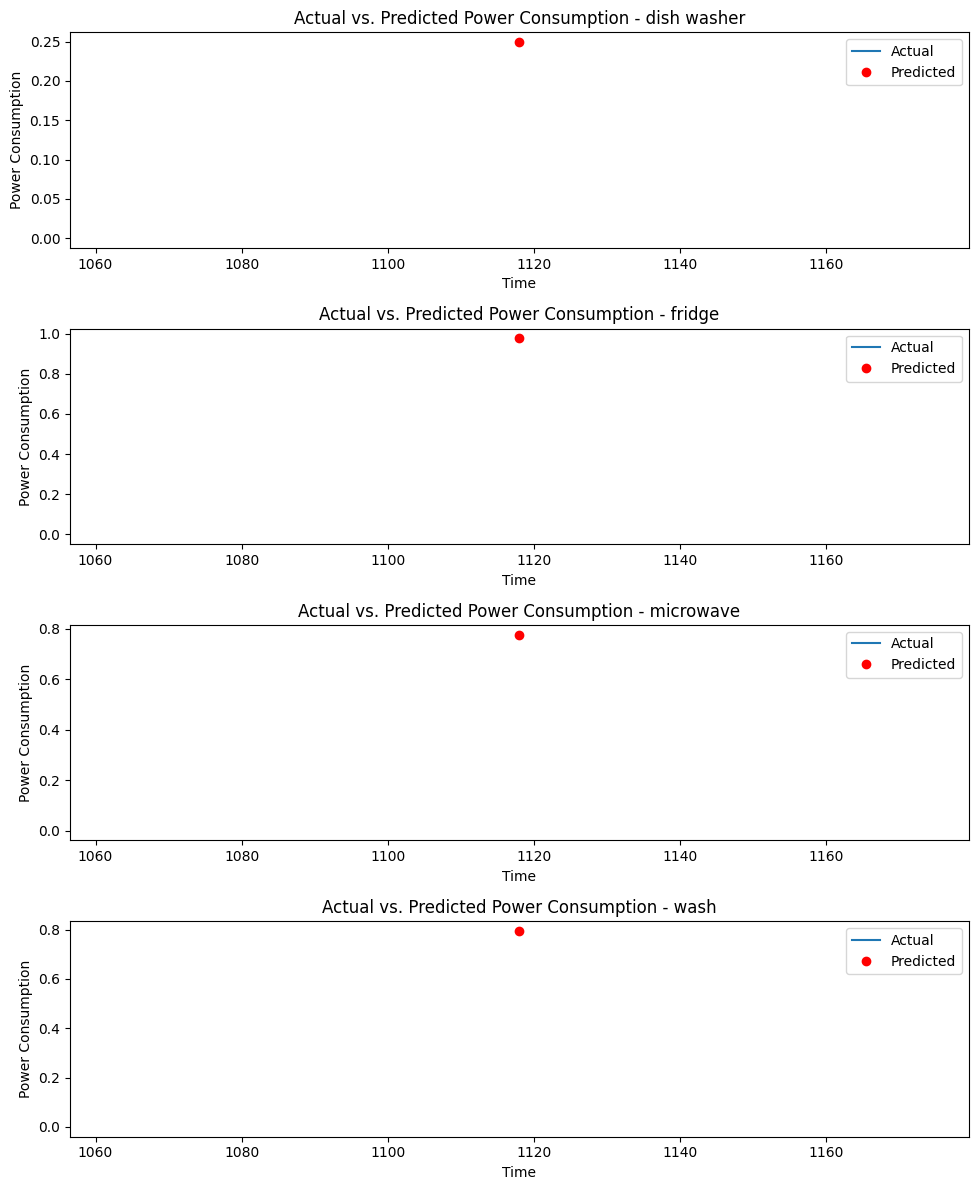

current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current sample count: 1119
Waiting for more data...
current samp

KeyboardInterrupt: 

In [ ]:


real_time_monitoring(input_sheet, model, config_dict, DEVICE)